In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import label_binarize, normalize

from utils import DataLoader, DataProcesser, label_plot, TimeKeeper

%load_ext autoreload
%autoreload 2

In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

In [8]:
col_drop_x = ['time', 'label']
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [9]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [10]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [20]:
def evaluate(y_true, y_pred, class_names = list(label_dic.values())):
    conf = confusion_matrix(y_true , y_pred)
    print(conf)
    sns.heatmap(conf)
    print(classification_report(y_true, y_pred, target_names = class_names))

# Bagging

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bag_reg = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True)
bag_reg.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500)

In [14]:
print(bag_reg.score(X_test,y_test))

0.6884542033390105


In [15]:
print(bag_reg.score(X_val, y_val))

0.6341155059114464


In [25]:
pred_bag = bag_reg.predict(X_val).tolist()

[[23348  1309    29    42     8   120   578  4402]
 [ 3703 17894   661   532   196  1170   735  1258]
 [   29  1530   788   315     0   106     1     5]
 [  235   640  1404  8341     7    22    17  1365]
 [ 1060   353    65  1680 12844  1626  2681   164]
 [ 1475   191    20   641   342  4015  1104  1390]
 [ 3929   225     0    81  4420   651 11151  1351]
 [ 1429    76     1    60   787   608  5843 12905]]
              precision    recall  f1-score   support

       Still       0.66      0.78      0.72     29836
     Walking       0.81      0.68      0.74     26149
         Run       0.27      0.28      0.27      2774
        Bike       0.71      0.69      0.70     12031
         Car       0.69      0.63      0.66     20473
         Bus       0.48      0.44      0.46      9178
       Train       0.50      0.51      0.51     21808
      Subway       0.57      0.59      0.58     21709

    accuracy                           0.63    143958
   macro avg       0.59      0.58      0.58    14

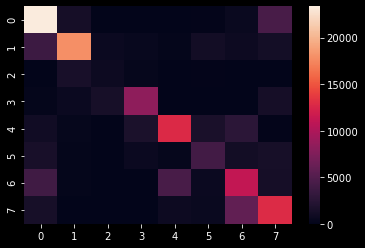

In [26]:
evaluate(y_val, pred_bag)